# Fake News Detector

### Fake news, defined by the Wikipedia as "a type of yellow journalism or propaganda that consists of deliberate misinformation or hoaxes spread via traditional print and broadcast news media or online social media".

### The goal of the Fake News Detector is to explore how Machine Learning and Natural Language Processing, might be leveraged to combat the fake news problem.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

## Data Exploration

### Data set from https://github.com/GeorgeMcIntire/fake_real_news_dataset. The data is in csv file and contains 6335 articles. Each article consists of unique id, title, body text, and label.

In [2]:
news_df = pd.read_csv('fake_or_real_news.csv')

Inspect shape of news

In [3]:
news_df.shape

(6335, 4)

In [4]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB


Print first lines of news

In [5]:
news_df.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


Set index

In [6]:
news_df.set_index('Unnamed: 0', inplace=True)
news_df.index.name = 'id'
news_df.head(10)

,title,text,label
id,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL


Drop "title" column

In [7]:
news_df.drop('title', axis=1, inplace=True)
news_df.head(10)

,text,label
id,,
8476,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,It's primary day in New York and front-runners...,REAL
6903,"\nI’m not an immigrant, but my grandparents ...",FAKE
7341,"Share This Baylee Luciani (left), Screenshot o...",FAKE
95,A Czech stockbroker who saved more than 650 Je...,REAL
4869,Hillary Clinton and Donald Trump made some ina...,REAL


News statistics

In [8]:
news_df.describe()

,text,label
count,6335,6335
unique,6060,2
top,"Killing Obama administration rules, dismantlin...",REAL
freq,58,3171


In [9]:
news_df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
FAKE   3164   3071                                                      36
REAL   3171   2989  Killing Obama administration rules, dismantlin...   58

Add length column

In [10]:
news_df['length'] = news_df['text'].apply(len)
news_df.head()

,text,label,length
id,,,
8476,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518
10294,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646
3608,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543
10142,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660
875,It's primary day in New York and front-runners...,REAL,1840


Histogram of news length

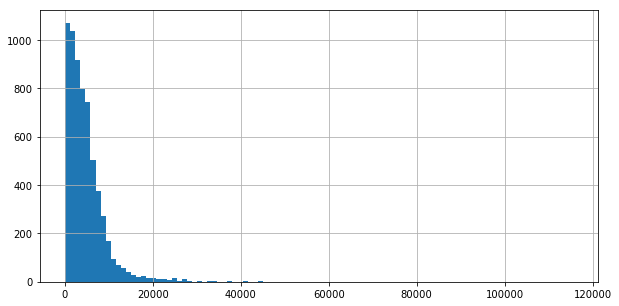

In [11]:
news_df['length'].hist(figsize=(10,5), bins=100)
plt.show()

News length stats

In [12]:
news_df['length'].describe()

count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: length, dtype: float64

Longest news

In [13]:
news_df[news_df['length'] == 115372]

,text,label,length
id,,,
7910,Why Are So Many People Choosing To Leave The U...,FAKE,115372


Delete empty news

In [14]:
news_df.drop(news_df.index[news_df['length'] == 1], inplace=True)

In [15]:
news_df.sort_values('length')[:10]

,text,label,length
id,,,
8751,11/08/2016,FAKE,12
6840,RECENT POSTS,FAKE,13
9368,Guest Guest,FAKE,17
7300,Gary North has the video . 12:56,FAKE,34
10452,Adrian Bamforth Adrian Bamforth,FAKE,37
6108,The Dark Art of Political Intimidation,FAKE,40
10329,"Posted: Nov 6th, 2016 by MADJEZ MADJEZ",FAKE,42
2623,Should the U.S. Continue to Support Israel?,REAL,43
10357,Hillary Clinton can’t believe she’s losing.,FAKE,45


News length histogram grouped by label

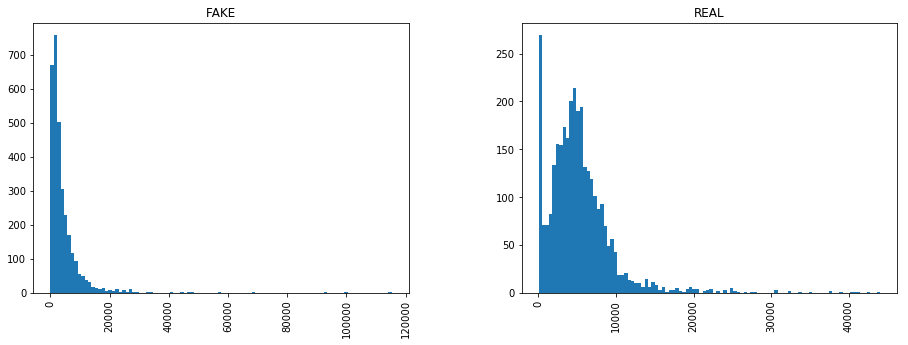

In [16]:
news_df.hist(column='length', by='label', figsize=(15,5), bins=100)
plt.show()

Plot a news lengths distribution

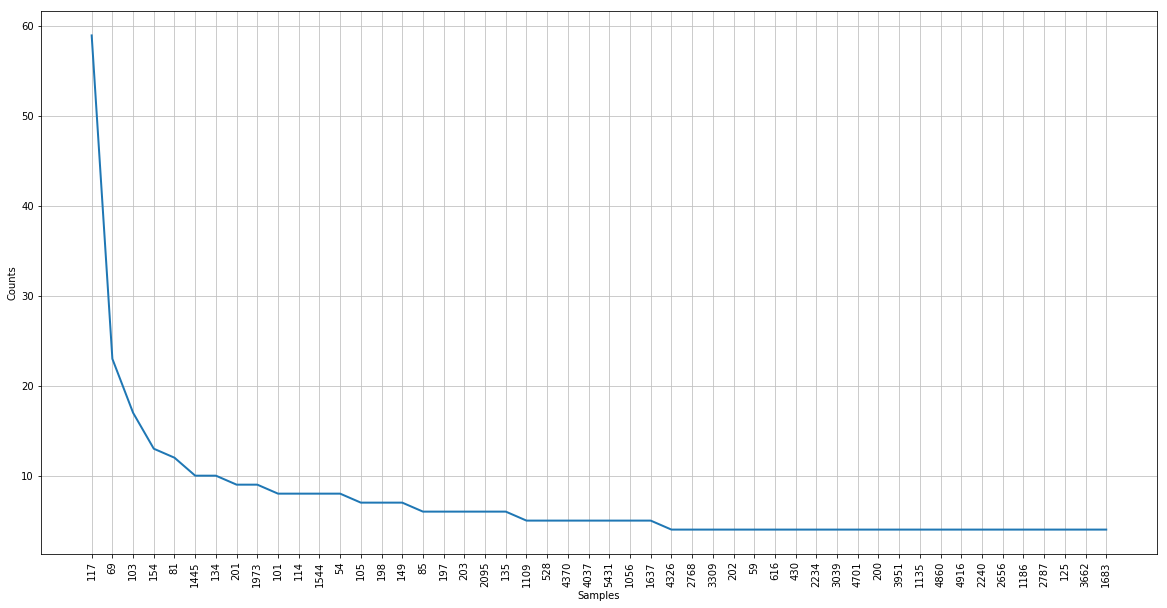

In [17]:
freq_dist = FreqDist(news_df['length'])
plt.figure(figsize=(20,10))
freq_dist.plot(50)
plt.show()

In [18]:
news_df[news_df['length']==117]

,text,label,length
id,,,
1571,"Killing Obama administration rules, dismantlin...",REAL,117
1661,"Killing Obama administration rules, dismantlin...",REAL,117
1329,"Killing Obama administration rules, dismantlin...",REAL,117
1570,"Killing Obama administration rules, dismantlin...",REAL,117
1610,"Killing Obama administration rules, dismantlin...",REAL,117
1597,"Killing Obama administration rules, dismantlin...",REAL,117
2376,"Killing Obama administration rules, dismantlin...",REAL,117
1590,"Killing Obama administration rules, dismantlin...",REAL,117
1742,"Killing Obama administration rules, dismantlin...",REAL,117


Remove duplicates

In [19]:
news_df.drop_duplicates(inplace=True)

Top 20 words

In [20]:
regexp_tokenizer = RegexpTokenizer(r"\w+")
stop_words = stopwords.words('english')

tokenized_news = [word for news in news_df['text'].values \
                  for word in regexp_tokenizer.tokenize(news) \
                  if word.lower() not in stop_words]
print(tokenized_news[:20])

['Daniel', 'Greenfield', 'Shillman', 'Journalism', 'Fellow', 'Freedom', 'Center', 'New', 'York', 'writer', 'focusing', 'radical', 'Islam', 'final', 'stretch', 'election', 'Hillary', 'Rodham', 'Clinton', 'gone']


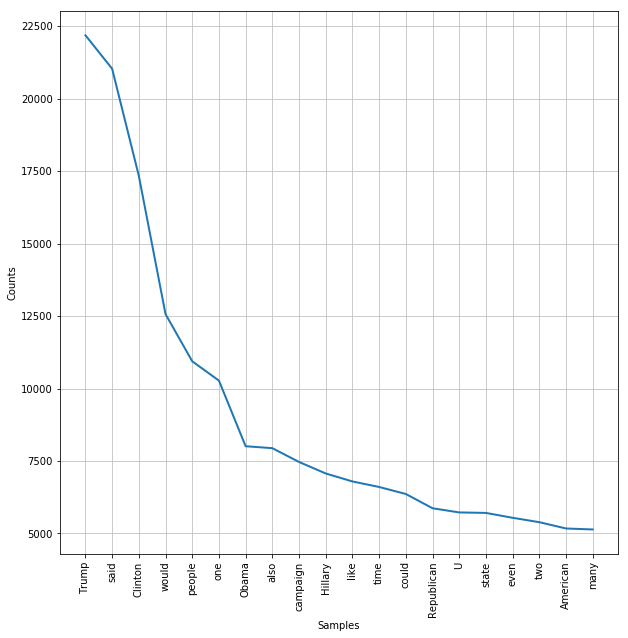

In [21]:
freq_dist = FreqDist(tokenized_news)
plt.figure(figsize=(10,10))
freq_dist.plot(20)

Top 20 "Fakest" words

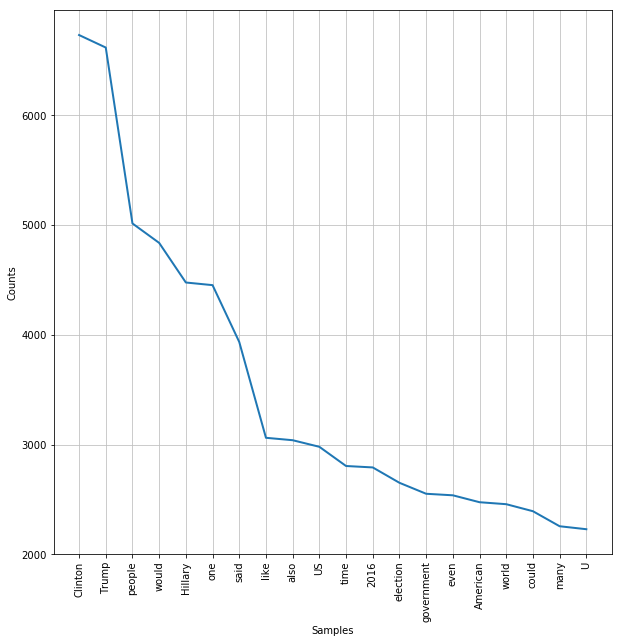

In [22]:
fake_news = news_df[news_df['label'] == 'FAKE']['text'].values
tokenized_fake_news = [word for news in fake_news \
                       for word in regexp_tokenizer.tokenize(news) \
                       if word.lower() not in stop_words]
freq_dist = FreqDist(tokenized_fake_news)
plt.figure(figsize=(10,10))
freq_dist.plot(20)

Top 20 "Realest" words

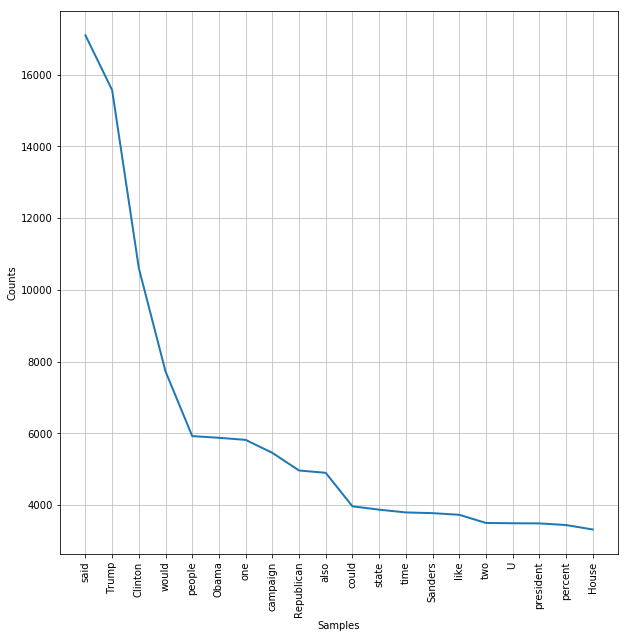

In [23]:
real_news = news_df[news_df['label'] == 'REAL']['text'].values
tokenized_real_news = [word for news in real_news \
                       for word in regexp_tokenizer.tokenize(news) \
                       if word.lower() not in stop_words]
freq_dist = FreqDist(tokenized_real_news)
plt.figure(figsize=(10,10))
freq_dist.plot(20)

### Extracting the training data

Set y

In [24]:
y = news_df['label']
y[:10]

id
8476     FAKE
10294    FAKE
3608     REAL
10142    FAKE
875      REAL
6903     FAKE
7341     FAKE
95       REAL
4869     REAL
2909     REAL
Name: label, dtype: object

Make training and test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(news_df['text'], y, test_size=0.33, random_state=101)

### Building Vectorizer Classifiers

Initialize the count_vectorizer

In [167]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Fit and transform the training data

In [168]:
X_train_count = count_vectorizer.fit_transform(X_train)
X_train_count

<4059x57106 sparse matrix of type '<class 'numpy.int64'>'
	with 1104246 stored elements in Compressed Sparse Row format>

Transform the test set

In [169]:
X_test_count = count_vectorizer.transform(X_test)
X_test_count

<2000x57106 sparse matrix of type '<class 'numpy.int64'>'
	with 534596 stored elements in Compressed Sparse Row format>

### Bag-of-words Exploration

In [31]:
X_train_count_df = pd.DataFrame(X_train_count.toarray(), columns=count_vectorizer.get_feature_names())
X_train_count_df.head(10)

,00,000,0000,000000031,000035,00006,0001pt,000billion,000ft,001,...,שעת,שתי,תאמצנה,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


count_vectorizer feature names

In [32]:
print(count_vectorizer.get_feature_names()[:20])

['00', '000', '0000', '000000031', '000035', '00006', '0001pt', '000billion', '000ft', '001', '0011', '002', '003', '004', '004s', '005', '006', '00684', '006s', '007']


In [33]:
print(count_vectorizer.get_feature_names()[-20:])

['שזו', 'שטחים', 'שינוי', 'שיתעקש', 'שכל', 'שכמוני', 'של', 'שלו', 'שנדרש', 'שני', 'שעת', 'שתי', 'תאמצנה', 'תוצאה', 'תחל', 'תיירות', 'תנותק', 'תעודת', 'תתרכז', 'ยงade']


count_vectorizer words amount

In [35]:
len(count_vectorizer.vocabulary_)

57106

Non zero entries in train and test sparse matrix

In [36]:
X_train_count.nnz, X_test_count.nnz

(1104246, 534596)

Sparcity

In [37]:
X_test_sparcity = (100.0 * X_test_count.nnz / (X_test_count.shape[0] * X_test_count.shape[1]))
X_train_sparcity = (100.0 * X_train_count.nnz / (X_train_count.shape[0] * X_train_count.shape[1]))
X_test_sparcity, X_train_sparcity

(0.4680734073477393, 0.4763926391058818)

### Building Multinomial Naive Bayes Classifier

In [38]:
model_nb = MultinomialNB()
model_nb

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Fit the classifier to the training data

In [39]:
model_nb.fit(X_train_count, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Create the predicted tags

In [40]:
y_pred = model_nb.predict(X_test_count)

Calculate the accuracy score

In [41]:
accuracy_score(y_test, y_pred)

0.88600000000000001

Calculate the confusion matrix

In [42]:
confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])

array([[867, 140],
       [ 88, 905]])

### MultinomialNB tuning

Create the list of alphas

In [172]:
alphas = np.arange(0, 1, 0.1)

In [173]:
for alpha in alphas:
    model_nb = MultinomialNB(alpha=alpha)
    model_nb.fit(X_train_count, y_train)
    y_pred = model_nb.predict(X_test_count)
    score = accuracy_score(y_test, y_pred)
    print('Alpha:', alpha, 'Score:', score)

Alpha: 0.0 Score: 0.6215
Alpha: 0.1 Score: 0.895
Alpha: 0.2 Score: 0.895
Alpha: 0.3 Score: 0.8945
Alpha: 0.4 Score: 0.8935
Alpha: 0.5 Score: 0.892
Alpha: 0.6 Score: 0.891
Alpha: 0.7 Score: 0.888
Alpha: 0.8 Score: 0.887
Alpha: 0.9 Score: 0.8875


/home/lukasz/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


### Binary Count Vectorizer Classifier

Initialize the binary_count_vectorizer

In [45]:
binary_count_vectorizer = CountVectorizer(stop_words='english', binary=True)
binary_count_vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Fit and transform the training data. Transform the test set

In [46]:
X_train_binary = binary_count_vectorizer.fit_transform(X_train)
X_test_binary = binary_count_vectorizer.transform(X_test)
X_train_binary.shape, X_test_binary.shape

((4059, 57106), (2000, 57106))

BoW Exploration

In [47]:
X_train_binary_df = pd.DataFrame(X_train_binary.toarray(), columns=binary_count_vectorizer.get_feature_names())
X_train_binary_df.head(10)

,00,000,0000,000000031,000035,00006,0001pt,000billion,000ft,001,...,שעת,שתי,תאמצנה,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculate the accuracy score

In [48]:
model_nb = MultinomialNB()
model_nb.fit(X_train_count, y_train)
y_pred = model_nb.predict(X_test_count)
accuracy_score(y_test, y_pred)

0.88600000000000001

### Term Frequency Vectorizer Classifiers

Initialize the tf_vectorizer

In [49]:
tf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, use_idf=False)
tf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=False,
        vocabulary=None)

Fit and transform the training data. Transform the test set

In [50]:
X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)
X_train_tf.shape, X_test_tf.shape

((4059, 57106), (2000, 57106))

BoW Exploration

In [51]:
X_train_tf_df = pd.DataFrame(X_train_tf.toarray(), columns=tf_vectorizer.get_feature_names())
X_train_tf_df.head(10)

,00,000,0000,000000031,000035,00006,0001pt,000billion,000ft,001,...,שעת,שתי,תאמצנה,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,ยงade
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.079556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.115214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.025880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate the accuracy score

In [52]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tf, y_train)
y_pred = model_nb.predict(X_test_tf)
accuracy_score(y_test, y_pred)

0.84250000000000003

### Term Frequency Inverse Document Frequency Vectorizer Classifiers

Initialize the tfidf_vectorizer

In [53]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Fit and transform the training data. Transform the test set

In [54]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((4059, 57106), (2000, 57106))

BoW Exploration

In [55]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
X_train_tfidf_df.head(10)

,00,000,0000,000000031,000035,00006,0001pt,000billion,000ft,001,...,שעת,שתי,תאמצנה,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,ยงade
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.058874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.071419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.018857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate the accuracy score

In [56]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred = model_nb.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

0.83499999999999996

### Building a pipeline

In [57]:
pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), \
                     ('classifier', MultinomialNB())
                    ])

In [58]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [59]:
y_pred = pipeline.predict(X_test)

In [60]:
accuracy_score(y_test, y_pred)

0.88700000000000001

### Random Forest Classifier

In [61]:
pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), \
                     ('classifier', RandomForestClassifier())
                    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.82499999999999996

### Support Vector Machine Classifier

In [63]:
pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), \
                     ('classifier', SVC())
                    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.83750000000000002

### Passive Aggressive Classifier

In [64]:
pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')), \
                     ('classifier', PassiveAggressiveClassifier())
                    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.87050000000000005

## Parameter tuning using grid search

In [63]:
models = ['MultinomialNB + CountVectorizer', 'MultinomialNB + TfidfVectorizer', \
          'Random Forest + CountVectorizer', 'RandomForest + TfidfVectorizer', \
          'SVC +  CountVectorizer', 'SVC + TfidfVectorizer', \
          'PassiveAggressiveClassifier + CountVectorizer', 'PassiveAggressiveClassifier + TfidfVectorizer']

In [64]:
pipelines = [Pipeline([('count', CountVectorizer(stop_words='english')), \
                       ('mnb', MultinomialNB()) \
                      ]), \
             Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), \
                       ('mnb', MultinomialNB()) \
                      ]), \
             Pipeline([('count', CountVectorizer(stop_words='english')), \
                       ('rfc', RandomForestClassifier()) \
                      ]), \
             Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), \
                       ('rfc', RandomForestClassifier()) \
                      ]), \
             Pipeline([('count', CountVectorizer(stop_words='english')), \
                       ('svc', SVC()) \
                      ]), \
             Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), \
                       ('svc', SVC()) \
                      ]), \
             Pipeline([('count', CountVectorizer(stop_words='english')), \
                       ('pac', PassiveAggressiveClassifier()) \
                      ]), \
             Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), \
                       ('pac', PassiveAggressiveClassifier()) \
                      ]) \
            ]

In [65]:
param_grids = [{'count__max_df': (0.8, 0.9, 1.0), \
                'count__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'count__binary': (True, False), \
                'mnb__alpha': (0.001, 0.01, 0.1, 0.2) \
               }, \
               {'tfidf__max_df': (0.8, 0.9, 1.0), \
                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'tfidf__use_idf': (True, False), \
                'tfidf__norm': ('l1', 'l2'), \
                'mnb__alpha': (0.001, 0.01, 0.1, 0.2) \
               }, \
               {'count__max_df': (0.8, 0.9, 1.0), \
                'count__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'count__binary': (True, False), \
                'rfc__n_estimators': (300, 500, 700, 900), \
                'rfc__max_features': ('sqrt', 'log2'), \
                'rfc__criterion': ('gini', 'entropy') \
               }, \
               {'tfidf__max_df': (0.8, 0.9, 1.0), \
                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'tfidf__use_idf': (True, False), \
                'tfidf__norm': ('l1', 'l2'), \
                'rfc__n_estimators': (300, 500, 700, 900), \
                'rfc__max_features': ('sqrt', 'log2'), \
                'rfc__criterion': ('gini', 'entropy') \
               }, \
               {'count__max_df': (0.6, 0.7, 0.8), \
                'count__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'count__binary': (True, False), \
                'svc__C': (0.001, 0.01, 0.1, 1), \
                'svc__kernel': ('linear', 'rbf') \
               }, \
               {'tfidf__max_df': (0.3, 0.4, 0.5), \
                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'tfidf__use_idf': (True, False), \
                'tfidf__norm': ('l1', 'l2'), \
                'svc__C': (0.1, 1, 3, 5), \
                'svc__kernel': ('linear', 'poly'), \
                'svc__degree': (3, 5, 10) \
               }, \
               {'count__max_df': (0.6, 0.7, 0.8), \
                'count__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'count__binary': (True, False), \
                'pac__loss': ('hinge', 'squared_hinge'), \
                'pac__n_iter': (5, 10, 20), \
               }, \
               {'tfidf__max_df': (0.6, 0.7, 0.8), \
                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], \
                'tfidf__use_idf': (True, False), \
                'tfidf__norm': ('l1', 'l2'), \
                'pac__loss': ('hinge', 'squared_hinge'), \
                'pac__n_iter': (5, 10, 20), \
               } \
              ]

### Search best params

In [67]:
best_params = []
for i in range(len(models)):
    cv = GridSearchCV(pipelines[i], param_grids[i], n_jobs=-1)
    cv.fit(X_train, y_train)
    best_params.append(cv.best_params_)

### Search best score

In [68]:
accuracy_scores = []
classification_reports = []

for i in range(len(models)):
    pipeline = deepcopy(pipelines[i])
    pipeline.set_params(**best_params[i])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred))

### Summary

In [69]:
for i in range(len(models)):
    print('Model:', models[i])
    print('Model best params:', best_params[i])
    print('Accuracy Score:', accuracy_scores[i])
    print('Classification Report:')
    print(classification_reports[i])
    print()

Model: MultinomialNB + CountVectorizer
Model best params: {'count__binary': False, 'count__max_df': 0.8, 'count__ngram_range': (1, 3), 'mnb__alpha': 0.01}
Accuracy Score: 0.914
Classification Report:
             precision    recall  f1-score   support

       FAKE       0.96      0.87      0.91      1007
       REAL       0.88      0.96      0.92       993

avg / total       0.92      0.91      0.91      2000


Model: MultinomialNB + TfidfVectorizer
Model best params: {'mnb__alpha': 0.001, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 3), 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Accuracy Score: 0.93
Classification Report:
             precision    recall  f1-score   support

       FAKE       0.94      0.92      0.93      1007
       REAL       0.92      0.94      0.93       993

avg / total       0.93      0.93      0.93      2000


Model: Random Forest + CountVectorizer
Model best params: {'count__binary': False, 'count__max_df': 1.0, 'count__ngram_range': (1, 1), 'rfc__criter

### BEST SCORE: 93% with TF-IDF (ngram: (1, 3) and l1 normalization) and Multinomial Naive Bayes (alpha=0.001)

- nie rozumiem wykresu w komórce 19 – co jest na osi x? Dlaczego nie są te liczby uporządkowane
Na osi x wykresu w komórce 19 jest długość artykułów, a na osi y liczba artykułów tej samej długości. Wykres pomaga zaobserwować zdublowane artykuły w zbiorze danych.


- po co macierz rzadka z word counts jest przerabiana na ramkę danych?
Word counts jest przerabiana na ramkę danych jest po to żeby przedstawić jak wygląda bag of words.


- tuning modelu robimy przy użyciu gridsearcha, a nie ręcznie pisanej pętli (mozna podać parametr cv tak, żeby nie robić iluskrotnej kroswalidacji, tylko pojedyncze sprawdzenie na podzial train/test)
Ręczna pętla jest zrobiona po to żeby pokazać jak zmienia sie accuracy score.


- dobrze by było żeby wszystkie te porównania pipline’ów odbywły się za jednym zamachem w pętli, a nie jeden kod jest potwtarzany wiele razy. I do tego na końcu powinna się znaleźć tabelka z zestawieniem wyników, bo takie wypisywanie liczb pomiedzy kodem jest niezbyt przyjazne w czytaniu



- dobrze widzę, że w analizie w ogóle nie są uwględniane tytuły artykułów? Jeśli tak, to przydałaby sie chociaż informacja o tym (tam gdzie bedzie opis danych), a najlepiej to byłoby je jakoś uwzględnić. Ale rozumiem, że to po prostu wymagałoby więcej pracy, więc nie musi tego być.

- zostały jakieś “to do” na dole.

Projekt merytorycznie jest ok. Ale do uzyskania zaliczenia trzeba go dopracować - ogólnie poprawić “prezencję” raportu.